In [1]:
# Import the necessary libraries
from PIL import Image
from numpy import asarray
import numpy as np
import os
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras.utils import np_utils
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
from sklearn.metrics import f1_score
print('all imported')

all imported


In [2]:
def readImage(filePath):
    img = Image.open(filePath)
    
    size=(30,40)
    #resize image
    out = img.resize(size)

    # asarray() class is used to convert
    # PIL images into NumPy arrays
    numpydata = asarray(out)
    numpydata = np.repeat(numpydata[:, :, np.newaxis], 3, axis=2)
    # <class 'numpy.ndarray'>
    #print(type(numpydata))

    #  shape
    #print(numpydata.shape)
    return numpydata
print(readImage('../../content/Benign/B_3141_1.RIGHT_CC.LJPEG.1_highpass.gif'))

[[[ 74  74  74]
  [ 83  83  83]
  [ 86  86  86]
  ...
  [108 108 108]
  [107 107 107]
  [102 102 102]]

 [[  8   8   8]
  [  8   8   8]
  [  7   7   7]
  ...
  [  9   9   9]
  [ 14  14  14]
  [ 25  25  25]]

 [[  8   8   8]
  [  7   7   7]
  [  7   7   7]
  ...
  [  9   9   9]
  [ 15  15  15]
  [ 27  27  27]]

 ...

 [[  8   8   8]
  [  7   7   7]
  [  7   7   7]
  ...
  [128 128 128]
  [ 87  87  87]
  [ 84  84  84]]

 [[  8   8   8]
  [  8   8   8]
  [  7   7   7]
  ...
  [ 66  66  66]
  [ 73  73  73]
  [ 77  77  77]]

 [[ 87  87  87]
  [ 70  70  70]
  [ 61  61  61]
  ...
  [ 85  85  85]
  [ 79  79  79]
  [ 73  73  73]]]


In [3]:
listFiles = os.listdir('../../content/Benign/')
print(listFiles[:5])

['B_3091_1.LEFT_CC.LJPEG.1_highpass.gif', 'B_3091_1.LEFT_MLO.LJPEG.1_highpass.gif', 'B_3093_1.LEFT_CC.LJPEG.1_highpass.gif', 'B_3093_1.LEFT_MLO.LJPEG.1_highpass.gif', 'B_3094_1.LEFT_CC.LJPEG.1_highpass.gif']


In [4]:
#load Benign
listCancer = []
listResults = []
for elem in listFiles:
    img = readImage('../../content/Benign/'+elem)
    listCancer += [img]
    listResults += [np.array([1])]
print(listCancer[:3])
print(img.shape)

[array([[[  5,   5,   5],
        [ 21,  21,  21],
        [ 13,  13,  13],
        ...,
        [  7,   7,   7],
        [  5,   5,   5],
        [  2,   2,   2]],

       [[ 23,  23,  23],
        [ 14,  14,  14],
        [  9,   9,   9],
        ...,
        [  1,   1,   1],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 23,  23,  23],
        [ 14,  14,  14],
        [  9,   9,   9],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 29,  29,  29],
        [ 17,  17,  17],
        [ 10,  10,  10],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128, 128, 128],
        [ 17,  17,  17],
        [ 12,  12,  12],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128, 128, 128],
        [128, 128, 128],
        [ 14,  14,  14],
        ...,
        [  7,   7,   7],
        [  6,   6,   6],
        [  6,   6,   6]

In [5]:
listFiles = os.listdir('../../content/Normal/')
print(listFiles[:5])
for elem in listFiles:
    img = readImage('../../content/Normal/'+elem)
    listResults += [np.array([0])]
    listCancer += [img]

['A_0002_1.LEFT_CC.LJPEG.1_highpass.gif', 'A_0002_1.LEFT_MLO.LJPEG.1_highpass.gif', 'A_0002_1.RIGHT_CC.LJPEG.1_highpass.gif', 'A_0002_1.RIGHT_MLO.LJPEG.1_highpass.gif', 'A_0003_1.LEFT_CC.LJPEG.1_highpass.gif']


In [6]:
listFiles = os.listdir('../../content/Malign/')
print(listFiles[:5])
for elem in listFiles:
    img = readImage('../../content/Malign/'+elem)
    listResults += [np.array([2])]
    listCancer += [img]

['B_3006_1.LEFT_CC.LJPEG.1_highpass.gif', 'B_3006_1.LEFT_MLO.LJPEG.1_highpass.gif', 'B_3011_1.LEFT_CC.LJPEG.1_highpass.gif', 'B_3011_1.LEFT_MLO.LJPEG.1_highpass.gif', 'B_3011_1.RIGHT_CC.LJPEG.1_highpass.gif']


In [7]:
print(len(listCancer))

300


In [8]:
def split_test():
    per = np.random.permutation(len(listCancer))
    ln = int(len(listCancer) * 0.8)
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    positions = []
    for i in range(ln):
        positions += [per[i]]
    for i in range(len(listCancer)):
        if i in positions:
            x_train += [listCancer[i]]
            y_train += [listResults[i]]
        else:
            x_test += [listCancer[i]]
            y_test += [listResults[i]]
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    x_test = np.array(x_test)
    y_test = np.array(y_test)

In [9]:
def prepare_data():
    # Setting Training Hyperparameters
    batch_size = 32 # original ResNet paper uses batch_size = 128 for training
    epochs = 10
    data_augmentation = True
    num_classes = 10

    # Data Preprocessing
    subtract_pixel_mean = True
    n = 3

    # Select ResNet Version
    version = 2

    # Computed depth of
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet % dv % d' % (depth, version)

    # use the data
    print(x_train[:3])
    print(y_train[:3])
    print(type(x_train[0]))
    print(type(x_train))
    print(type(y_train[0]))
    print(type(y_train))

    # Input image dimensions.
    input_shape = x_train.shape[1:]
    print(input_shape)

    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis = 0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    # Print Training and Test Samples
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)

    # Convert class vectors to binary class matrices.
    y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [10]:
# Setting LR for different number of Epochs
def lr_schedule(epoch):
	lr = 1e-3
	if epoch > 180:
		lr *= 0.5e-3
	elif epoch > 160:
		lr *= 1e-3
	elif epoch > 120:
		lr *= 1e-2
	elif epoch > 80:
		lr *= 1e-1
	print('Learning rate: ', lr)
	return lr


In [11]:
# Basic ResNet Building Block
def resnet_layer(inputs, conv_first = False,
				num_filters = 16,
				kernel_size = 3,
				strides = 1,
				activation ='relu',
				batch_normalization = True):
	conv = Conv2D(num_filters,
				kernel_size = kernel_size,
				strides = strides,
				padding ='same',
				kernel_initializer ='he_normal',
				kernel_regularizer = l2(1e-4))

	x = inputs
	if conv_first:
		x = conv(x)
		if batch_normalization:
			x = BatchNormalization()(x)
		if activation is not None:
			x = Activation(activation)(x)
	else:
		if batch_normalization:
			x = BatchNormalization()(x)
		if activation is not None:
			x = Activation(activation)(x)
		x = conv(x)
	return x

In [12]:
# ResNet V2 architecture
def resnet_v2(input_shape, depth, num_classes = 10):
	if (depth - 2) % 9 != 0:
		raise ValueError('depth should be 9n + 2 (eg 56 or 110 in [b])')
	# Start model definition.
	num_filters_in = 16
	num_res_blocks = int((depth - 2) / 9)

	inputs = Input(shape = input_shape)
	# v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
	x = resnet_layer(inputs = inputs,num_filters = num_filters_in,conv_first = True)

	# Instantiate the stack of residual units
	for stage in range(3):
		for res_block in range(num_res_blocks):
			activation = 'relu'
			batch_normalization = True
			strides = 1
			if stage == 0:
				num_filters_out = num_filters_in * 4
				if res_block == 0: # first layer and first stage
					activation = None
					batch_normalization = False
			else:
				num_filters_out = num_filters_in * 2
				if res_block == 0: # first layer but not first stage
					strides = 2 # downsample

			# bottleneck residual unit
			y = resnet_layer(inputs = x,
							num_filters = num_filters_in,
							kernel_size = 1,
							strides = strides,
							activation = activation,
							batch_normalization = batch_normalization)
			y = resnet_layer(inputs = y,
							num_filters = num_filters_in,
							conv_first = False)
			y = resnet_layer(inputs = y,
							num_filters = num_filters_out,
							kernel_size = 1,
							conv_first = False)
			if res_block == 0:
				# linear projection residual shortcut connection to match
				# changed dims
				x = resnet_layer(inputs = x,
								num_filters = num_filters_out,
								kernel_size = 1,
								strides = strides,
								activation = None,
								batch_normalization = False)
			x = keras.layers.add([x, y])

		num_filters_in = num_filters_out

	# Add classifier on top.
	# v2 has BN-ReLU before Pooling
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = AveragePooling2D(pool_size = 8)(x)
	y = Flatten()(x)
	outputs = Dense(num_classes,
					activation ='softmax',
					kernel_initializer ='he_normal')(y)

	# Instantiate model.
	model = Model(inputs = inputs, outputs = outputs)
	return model

In [13]:
x_train=[]
y_train=[]
accs=[]

precisions = []
recalls = []
def main(pz):
    
    per = np.random.permutation(len(listCancer))
    ln = int(len(listCancer) * 0.8)
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    positions = []
    for i in range(ln):
        positions += [per[i]]
    for i in range(len(listCancer)):
        if i in positions:
            x_train += [listCancer[i]]
            y_train += [listResults[i]]
        else:
            x_test += [listCancer[i]]
            y_test += [listResults[i]]
            
    ln = len(x_test) // 2
    
    x_valid = x_test[ln:]
    y_valid = y_test[ln:]
    
    x_test = x_test[:ln]
    y_test = y_test[:ln]
    
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_valid = np.array(x_valid)
    y_valid = np.array(y_valid)
    
    
    batch_size = 32 # original ResNet paper uses batch_size = 128 for training
    epochs = 10
    data_augmentation = True
    num_classes = 10

    # Data Preprocessing
    subtract_pixel_mean = True
    n = 3

    # Select ResNet Version
    version = 2

    # Computed depth of
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet % dv % d' % (depth, version)

    # use the data
    print(x_train[:3])
    print(y_train[:3])
    print(type(x_train[0]))
    print(type(x_train))
    print(type(y_train[0]))
    print(type(y_train))

    # Input image dimensions.
    input_shape = x_train.shape[1:]
    print(input_shape)

    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    x_valid = x_test.astype('float32') / 255

    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis = 0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    # Print Training and Test Samples
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)

    # Convert class vectors to binary class matrices.
    y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
    y_valid = keras.utils.np_utils.to_categorical(y_valid, num_classes)
    
    
    model = resnet_v2(input_shape = input_shape, depth = depth)

    model.compile(loss ='categorical_crossentropy',
                optimizer = Adam(learning_rate = lr_schedule(0)),
                metrics =['accuracy'])
    model.summary()
    print(model_type)

    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'cifar10_% s_model.{epoch:03d}.h5' % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)

    # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(filepath = filepath,
                                monitor ='val_acc',
                                verbose = 1,
                                save_best_only = True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                                cooldown = 0,
                                patience = 5,
                                min_lr = 0.5e-6)

    callbacks = [checkpoint, lr_reducer, lr_scheduler]

    # Run training, with or without data augmentation.
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                batch_size = batch_size,
                epochs = epochs,
                validation_data =(x_test, y_test),
                shuffle = True,
                callbacks = callbacks)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center = False,
            # set each sample mean to 0
            samplewise_center = False,
            # divide inputs by std of dataset
            featurewise_std_normalization = False,
            # divide each input by its std
            samplewise_std_normalization = False,
            # apply ZCA whitening
            zca_whitening = False,
            # epsilon for ZCA whitening
            zca_epsilon = 1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range = 0,
            # randomly shift images horizontally
            width_shift_range = 0.1,
            # randomly shift images vertically
            height_shift_range = 0.1,
            # set range for random shear
            shear_range = 0.,
            # set range for random zoom
            zoom_range = 0.,
            # set range for random channel shifts
            channel_shift_range = 0.,
            # set mode for filling points outside the input boundaries
            fill_mode ='nearest',
            # value used for fill_mode = "constant"
            cval = 0.,
            # randomly flip images
            horizontal_flip = True,
            # randomly flip images
            vertical_flip = False,
            # set rescaling factor (applied before any other transformation)
            rescale = None,
            # set function that will be applied on each input
            preprocessing_function = None,
            # image data format, either "channels_first" or "channels_last"
            data_format = None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split = 0.1)

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        print('------------------')
        print(x_train)
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                            validation_data =(x_valid, y_valid),
                            epochs = 100, verbose = 1, workers = 4,
                            callbacks = callbacks)

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose = 1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    ret = model.predict(x_test)
    result = []
    pred = []
    for a,b in zip(ret, y_test):
        pred+=[a.argmax(axis=-1)]
        result+=[b.argmax(axis=-1)]
    print(pred)
    print(result)
    precision = precision_score(result, pred, average='weighted')
    recall = recall_score(result, pred, average='weighted')
     # calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
    fmeasure = f1_score(result, pred, average='weighted')
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 Score: ', fmeasure)
    #precisions += [precision]
    #recalls += [recall]
    #model.save('saved_models/resNetV'+pz+'.h5')
    return [scores[1], precision, recall, fmeasure]

In [14]:
accs=[]
precisions = []
recalls = []
fmeasures = []
for i in range(10):
    ret = main(i)
    accs+=[ret[0]]
    precisions+=[ret[1]]
    recalls+=[ret[2]]
    fmeasures+=[ret[3]]
print(accs)
print(precisions)
print(recalls)
print(fmeasures)

[[[[  5   5   5]
   [ 21  21  21]
   [ 13  13  13]
   ...
   [  7   7   7]
   [  5   5   5]
   [  2   2   2]]

  [[ 23  23  23]
   [ 14  14  14]
   [  9   9   9]
   ...
   [  1   1   1]
   [  0   0   0]
   [  0   0   0]]

  [[ 23  23  23]
   [ 14  14  14]
   [  9   9   9]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[ 29  29  29]
   [ 17  17  17]
   [ 10  10  10]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[128 128 128]
   [ 17  17  17]
   [ 12  12  12]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[128 128 128]
   [128 128 128]
   [ 14  14  14]
   ...
   [  7   7   7]
   [  6   6   6]
   [  6   6   6]]]


 [[[108 108 108]
   [117 117 117]
   [116 116 116]
   ...
   [  1   1   1]
   [  1   1   1]
   [  1   1   1]]

  [[112 112 112]
   [108 108 108]
   [115 115 115]
   ...
   [  1   1   1]
   [  1   1   1]
   [  1   1   1]]

  [[117 117 117]
   [112 112 112]
   [110 110 110]
   ...
   [  1   1   1]
   [  1   1   1]
   [  1   1

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
Learning rate:  0.001
8/8 [==============================] - 13s 1s/step - loss: 2.1606 - accuracy: 0.4750 - val_loss: 2.8952 - val_accuracy: 0.2000
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 6s 700ms/step - loss: 1.3334 - accuracy: 0.6667 - val_loss: 2.6669 - val_accuracy: 0.0000e+00
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 6s 773ms/step - loss: 1.1759 - accuracy: 0.6958 - val_loss: 2.5575 - val_accuracy: 0.0000e+00
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 6s 737ms/step - loss: 1.1136 - accuracy: 0.7250 - val_loss: 2.6588 - val_accuracy: 0.0000e+00
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 6s 777ms/step - loss: 1.1363 - accuracy: 0.7375 - val_loss: 2.4833 - val_accuracy: 0.0000e+00
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 9s 1s/step - loss: 1.1012 - accuracy: 0.7042 - val_loss: 2.6173 - val_accuracy: 0.0000e+00
Epoch 7

8/8 [==============================] - 7s 789ms/step - loss: 0.6834 - accuracy: 0.8625 - val_loss: 11.9517 - val_accuracy: 0.0000e+00
Epoch 68/100
Learning rate:  0.001
8/8 [==============================] - 7s 795ms/step - loss: 0.6792 - accuracy: 0.8542 - val_loss: 12.3414 - val_accuracy: 0.0000e+00
Epoch 69/100
Learning rate:  0.001
8/8 [==============================] - 7s 798ms/step - loss: 0.6214 - accuracy: 0.9000 - val_loss: 16.8427 - val_accuracy: 0.0000e+00
Epoch 70/100
Learning rate:  0.001
8/8 [==============================] - 7s 849ms/step - loss: 0.5883 - accuracy: 0.9083 - val_loss: 18.3523 - val_accuracy: 0.0000e+00
Epoch 71/100
Learning rate:  0.001
8/8 [==============================] - 7s 839ms/step - loss: 0.6014 - accuracy: 0.9083 - val_loss: 14.7044 - val_accuracy: 0.0000e+00
Epoch 72/100
Learning rate:  0.001
8/8 [==============================] - 7s 848ms/step - loss: 0.6023 - accuracy: 0.9000 - val_loss: 14.4246 - val_accuracy: 0.0000e+00
Epoch 73/100
Learning

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 40, 30, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 40, 30, 16)   64          conv2d_31[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 40, 30, 16)   0           batch_normalization_28[0][0]     
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
Learning rate:  0.001
8/8 [==============================] - 12s 991ms/step - loss: 2.1159 - accuracy: 0.4875 - val_loss: 2.6769 - val_accuracy: 0.4333
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 7s 789ms/step - loss: 1.3873 - accuracy: 0.6292 - val_loss: 2.5402 - val_accuracy: 0.5667
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 7s 808ms/step - loss: 1.2339 - accuracy: 0.6875 - val_loss: 2.3353 - val_accuracy: 0.5667
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 7s 804ms/step - loss: 1.1620 - accuracy: 0.6833 - val_loss: 2.2378 - val_accuracy: 0.5667
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 6s 711ms/step - loss: 1.1618 - accuracy: 0.7083 - val_loss: 2.4102 - val_accuracy: 0.5667
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 790ms/step - loss: 1.1098 - accuracy: 0.7125 - val_loss: 2.3833 - val_accuracy: 0.5667
Epoch 7/100
Learning 

Epoch 35/100
Learning rate:  0.001
8/8 [==============================] - 6s 728ms/step - loss: 0.8333 - accuracy: 0.8125 - val_loss: 8.6643 - val_accuracy: 0.0000e+00
Epoch 36/100
Learning rate:  0.001
8/8 [==============================] - 6s 741ms/step - loss: 0.7483 - accuracy: 0.8583 - val_loss: 5.2074 - val_accuracy: 0.5667
Epoch 37/100
Learning rate:  0.001
8/8 [==============================] - 6s 667ms/step - loss: 0.8152 - accuracy: 0.8333 - val_loss: 4.1845 - val_accuracy: 0.5667
Epoch 38/100
Learning rate:  0.001
8/8 [==============================] - 5s 648ms/step - loss: 0.7836 - accuracy: 0.8458 - val_loss: 16.0921 - val_accuracy: 0.0000e+00
Epoch 39/100
Learning rate:  0.001
8/8 [==============================] - 6s 687ms/step - loss: 0.7024 - accuracy: 0.8917 - val_loss: 2.8385 - val_accuracy: 0.5333
Epoch 40/100
Learning rate:  0.001
8/8 [==============================] - 6s 681ms/step - loss: 0.6980 - accuracy: 0.8958 - val_loss: 19.1573 - val_accuracy: 0.0000e+00
Ep

1/1 [==============================] - 0s 471ms/step - loss: 0.6708 - accuracy: 0.8333
Test loss: 0.6707844138145447
Test accuracy: 0.8333333134651184
[1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision:  1.0
Recall:  0.8333333333333334
F1 Score:  0.9032258064516128
[[[[  5   5   5]
   [ 21  21  21]
   [ 13  13  13]
   ...
   [  7   7   7]
   [  5   5   5]
   [  2   2   2]]

  [[ 23  23  23]
   [ 14  14  14]
   [  9   9   9]
   ...
   [  1   1   1]
   [  0   0   0]
   [  0   0   0]]

  [[ 23  23  23]
   [ 14  14  14]
   [  9   9   9]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[ 29  29  29]
   [ 17  17  17]
   [ 10  10  10]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[128 128 128]
   [ 17  17  17]
   [ 12  12  12]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[128 128 128]
   [128 128 12

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 40, 30, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 40, 30, 16)   64          conv2d_62[0][0]                  
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 40, 30, 16)   0           batch_normalization_56[0][0]     
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
Learning rate:  0.001
8/8 [==============================] - 11s 853ms/step - loss: 1.9462 - accuracy: 0.4833 - val_loss: 2.3874 - val_accuracy: 0.2333
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 6s 765ms/step - loss: 1.3042 - accuracy: 0.6500 - val_loss: 1.7928 - val_accuracy: 0.7667
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 6s 710ms/step - loss: 1.1674 - accuracy: 0.6667 - val_loss: 2.1596 - val_accuracy: 0.7667
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 6s 750ms/step - loss: 1.1130 - accuracy: 0.7292 - val_loss: 2.3136 - val_accuracy: 0.7667
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 6s 720ms/step - loss: 1.0943 - accuracy: 0.7667 - val_loss: 1.8328 - val_accuracy: 0.7667
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 711ms/step - loss: 1.0655 - accuracy: 0.7375 - val_loss: 2.2091 - val_accuracy: 0.7667
Epoch 7/100
Learning 

Epoch 35/100
Learning rate:  0.001
8/8 [==============================] - 6s 766ms/step - loss: 0.7649 - accuracy: 0.8542 - val_loss: 8.8305 - val_accuracy: 0.0000e+00
Epoch 36/100
Learning rate:  0.001
8/8 [==============================] - 6s 762ms/step - loss: 0.8002 - accuracy: 0.8167 - val_loss: 13.8855 - val_accuracy: 0.0000e+00
Epoch 37/100
Learning rate:  0.001
8/8 [==============================] - 6s 816ms/step - loss: 0.7557 - accuracy: 0.8583 - val_loss: 14.8447 - val_accuracy: 0.0000e+00
Epoch 38/100
Learning rate:  0.001
8/8 [==============================] - 6s 741ms/step - loss: 0.7404 - accuracy: 0.8792 - val_loss: 15.4199 - val_accuracy: 0.0000e+00
Epoch 39/100
Learning rate:  0.001
8/8 [==============================] - 7s 863ms/step - loss: 0.7271 - accuracy: 0.8958 - val_loss: 16.9223 - val_accuracy: 0.0000e+00
Epoch 40/100
Learning rate:  0.001
8/8 [==============================] - 6s 709ms/step - loss: 0.7351 - accuracy: 0.8667 - val_loss: 15.9851 - val_accuracy

Epoch 68/100
Learning rate:  0.001
8/8 [==============================] - 7s 828ms/step - loss: 0.5760 - accuracy: 0.9292 - val_loss: 15.2324 - val_accuracy: 0.0000e+00
Epoch 69/100
Learning rate:  0.001
8/8 [==============================] - 7s 821ms/step - loss: 0.6457 - accuracy: 0.8958 - val_loss: 11.7532 - val_accuracy: 0.0000e+00
Epoch 70/100
Learning rate:  0.001
8/8 [==============================] - 7s 802ms/step - loss: 0.5296 - accuracy: 0.9417 - val_loss: 18.5749 - val_accuracy: 0.0000e+00
Epoch 71/100
Learning rate:  0.001
8/8 [==============================] - 7s 900ms/step - loss: 0.5647 - accuracy: 0.9292 - val_loss: 21.7748 - val_accuracy: 0.0000e+00
Epoch 72/100
Learning rate:  0.001
8/8 [==============================] - 6s 773ms/step - loss: 0.5717 - accuracy: 0.9208 - val_loss: 23.8616 - val_accuracy: 0.0000e+00
Epoch 73/100
Learning rate:  0.001
8/8 [==============================] - 6s 768ms/step - loss: 0.5210 - accuracy: 0.9417 - val_loss: 24.3228 - val_accurac

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 40, 30, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 40, 30, 16)   64          conv2d_93[0][0]                  
__________________________________________________________________________________________________
activation_84 (Activation)      (None, 40, 30, 16)   0           batch_normalization_84[0][0]     
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8/8 [==============================] - 11s 763ms/step - loss: 2.4000 - accuracy: 0.4125 - val_loss: 2.7979 - val_accuracy: 0.0000e+00
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 6s 678ms/step - loss: 1.4412 - accuracy: 0.6667 - val_loss: 2.5438 - val_accuracy: 0.0000e+00
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 6s 715ms/step - loss: 1.1919 - accuracy: 0.6833 - val_loss: 2.5925 - val_accuracy: 0.0000e+00
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 5s 617ms/step - loss: 1.1321 - accuracy: 0.7458 - val_loss: 2.7518 - val_accuracy: 0.0000e+00
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 5s 617ms/step - loss: 1.1400 - accuracy: 0.7167 - val_loss: 2.4173 - val_accuracy: 0.7000
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 784ms/step - loss: 1.1051 - accuracy: 0.7458 - val_loss: 2.7038 - val_accuracy: 0.0000e+00
Epoch 7/100
Learning rate:  0.001
8

Epoch 35/100
Learning rate:  0.001
8/8 [==============================] - 5s 667ms/step - loss: 0.7551 - accuracy: 0.8500 - val_loss: 15.4557 - val_accuracy: 0.0000e+00
Epoch 36/100
Learning rate:  0.001
8/8 [==============================] - 5s 659ms/step - loss: 0.7874 - accuracy: 0.8375 - val_loss: 16.8421 - val_accuracy: 0.0000e+00
Epoch 37/100
Learning rate:  0.001
8/8 [==============================] - 5s 657ms/step - loss: 0.8027 - accuracy: 0.8375 - val_loss: 12.7408 - val_accuracy: 0.0000e+00
Epoch 38/100
Learning rate:  0.001
8/8 [==============================] - 5s 660ms/step - loss: 0.7681 - accuracy: 0.8625 - val_loss: 13.3012 - val_accuracy: 0.0000e+00
Epoch 39/100
Learning rate:  0.001
8/8 [==============================] - 5s 719ms/step - loss: 0.7967 - accuracy: 0.8167 - val_loss: 9.4915 - val_accuracy: 0.0000e+00
Epoch 40/100
Learning rate:  0.001
8/8 [==============================] - 5s 660ms/step - loss: 0.7510 - accuracy: 0.8625 - val_loss: 10.3171 - val_accuracy

Epoch 68/100
Learning rate:  0.001
8/8 [==============================] - 5s 608ms/step - loss: 0.5420 - accuracy: 0.9417 - val_loss: 20.0834 - val_accuracy: 0.0000e+00
Epoch 69/100
Learning rate:  0.001
8/8 [==============================] - 6s 760ms/step - loss: 0.5253 - accuracy: 0.9292 - val_loss: 21.5079 - val_accuracy: 0.0000e+00
Epoch 70/100
Learning rate:  0.001
8/8 [==============================] - 6s 720ms/step - loss: 0.5770 - accuracy: 0.8958 - val_loss: 15.4381 - val_accuracy: 0.0000e+00
Epoch 71/100
Learning rate:  0.001
8/8 [==============================] - 7s 854ms/step - loss: 0.5690 - accuracy: 0.9250 - val_loss: 14.0894 - val_accuracy: 0.0000e+00
Epoch 72/100
Learning rate:  0.001
8/8 [==============================] - 6s 742ms/step - loss: 0.5625 - accuracy: 0.9042 - val_loss: 17.3624 - val_accuracy: 0.0000e+00
Epoch 73/100
Learning rate:  0.001
8/8 [==============================] - 5s 623ms/step - loss: 0.5241 - accuracy: 0.9208 - val_loss: 19.3413 - val_accurac

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 40, 30, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 40, 30, 16)   64          conv2d_124[0][0]                 
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 40, 30, 16)   0           batch_normalization_112[0][0]    
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8/8 [==============================] - 11s 788ms/step - loss: 2.1080 - accuracy: 0.5000 - val_loss: 2.6607 - val_accuracy: 0.3000
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 6s 687ms/step - loss: 1.3530 - accuracy: 0.6708 - val_loss: 2.5621 - val_accuracy: 0.3000
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 6s 685ms/step - loss: 1.1913 - accuracy: 0.7000 - val_loss: 2.7005 - val_accuracy: 0.0000e+00
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 6s 740ms/step - loss: 1.1491 - accuracy: 0.7167 - val_loss: 3.3968 - val_accuracy: 0.0000e+00
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 6s 786ms/step - loss: 1.0958 - accuracy: 0.7167 - val_loss: 3.8371 - val_accuracy: 0.0000e+00
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 798ms/step - loss: 1.1060 - accuracy: 0.7375 - val_loss: 5.0475 - val_accuracy: 0.0000e+00
Epoch 7/100
Learning rate:  0.001
8/8 [

8/8 [==============================] - 6s 790ms/step - loss: 0.5530 - accuracy: 0.9333 - val_loss: 21.6240 - val_accuracy: 0.0000e+00
Epoch 68/100
Learning rate:  0.001
8/8 [==============================] - 6s 745ms/step - loss: 0.5150 - accuracy: 0.9500 - val_loss: 24.7176 - val_accuracy: 0.0000e+00
Epoch 69/100
Learning rate:  0.001
8/8 [==============================] - 6s 767ms/step - loss: 0.5149 - accuracy: 0.9417 - val_loss: 26.9282 - val_accuracy: 0.0000e+00
Epoch 70/100
Learning rate:  0.001
8/8 [==============================] - 6s 734ms/step - loss: 0.5592 - accuracy: 0.9250 - val_loss: 31.1229 - val_accuracy: 0.0000e+00
Epoch 71/100
Learning rate:  0.001
8/8 [==============================] - 6s 760ms/step - loss: 0.5366 - accuracy: 0.9292 - val_loss: 18.2307 - val_accuracy: 0.0000e+00
Epoch 72/100
Learning rate:  0.001
8/8 [==============================] - 6s 723ms/step - loss: 0.5670 - accuracy: 0.9375 - val_loss: 21.0685 - val_accuracy: 0.0000e+00
Epoch 73/100
Learning

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_155 (Conv2D)             (None, 40, 30, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_140 (BatchN (None, 40, 30, 16)   64          conv2d_155[0][0]                 
__________________________________________________________________________________________________
activation_140 (Activation)     (None, 40, 30, 16)   0           batch_normalization_140[0][0]    
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8/8 [==============================] - 11s 834ms/step - loss: 2.3610 - accuracy: 0.4208 - val_loss: 4.0334 - val_accuracy: 0.0667
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 6s 706ms/step - loss: 1.3200 - accuracy: 0.7042 - val_loss: 2.4527 - val_accuracy: 0.0000e+00
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 6s 757ms/step - loss: 1.2035 - accuracy: 0.7292 - val_loss: 2.5474 - val_accuracy: 0.0000e+00
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 6s 781ms/step - loss: 1.1764 - accuracy: 0.7333 - val_loss: 2.8896 - val_accuracy: 0.0000e+00
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 6s 732ms/step - loss: 1.0848 - accuracy: 0.7583 - val_loss: 3.3240 - val_accuracy: 0.0000e+00
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 708ms/step - loss: 1.0658 - accuracy: 0.7708 - val_loss: 3.5039 - val_accuracy: 0.0000e+00
Epoch 7/100
Learning rate:  0.001
8

Epoch 35/100
Learning rate:  0.001
8/8 [==============================] - 6s 718ms/step - loss: 0.7954 - accuracy: 0.8333 - val_loss: 15.3519 - val_accuracy: 0.0000e+00
Epoch 36/100
Learning rate:  0.001
8/8 [==============================] - 6s 710ms/step - loss: 0.7388 - accuracy: 0.8625 - val_loss: 12.0815 - val_accuracy: 0.0000e+00
Epoch 37/100
Learning rate:  0.001
8/8 [==============================] - 6s 704ms/step - loss: 0.7819 - accuracy: 0.8500 - val_loss: 16.0374 - val_accuracy: 0.0000e+00
Epoch 38/100
Learning rate:  0.001
8/8 [==============================] - 6s 776ms/step - loss: 0.7302 - accuracy: 0.8833 - val_loss: 17.2687 - val_accuracy: 0.0000e+00
Epoch 39/100
Learning rate:  0.001
8/8 [==============================] - 6s 730ms/step - loss: 0.6889 - accuracy: 0.8958 - val_loss: 13.4970 - val_accuracy: 0.0000e+00
Epoch 40/100
Learning rate:  0.001
8/8 [==============================] - 6s 769ms/step - loss: 0.7420 - accuracy: 0.8792 - val_loss: 17.1060 - val_accurac

Epoch 68/100
Learning rate:  0.001
8/8 [==============================] - 8s 1s/step - loss: 0.5831 - accuracy: 0.9000 - val_loss: 16.9137 - val_accuracy: 0.0000e+00
Epoch 69/100
Learning rate:  0.001
8/8 [==============================] - 8s 945ms/step - loss: 0.5795 - accuracy: 0.9125 - val_loss: 15.9284 - val_accuracy: 0.0000e+00
Epoch 70/100
Learning rate:  0.001
8/8 [==============================] - 8s 942ms/step - loss: 0.5521 - accuracy: 0.9083 - val_loss: 18.6656 - val_accuracy: 0.0000e+00
Epoch 71/100
Learning rate:  0.001
8/8 [==============================] - 7s 853ms/step - loss: 0.6289 - accuracy: 0.8875 - val_loss: 20.0095 - val_accuracy: 0.0000e+00
Epoch 72/100
Learning rate:  0.001
8/8 [==============================] - 7s 789ms/step - loss: 0.6486 - accuracy: 0.8708 - val_loss: 14.5935 - val_accuracy: 0.0000e+00
Epoch 73/100
Learning rate:  0.001
8/8 [==============================] - 6s 737ms/step - loss: 0.5497 - accuracy: 0.9292 - val_loss: 13.1773 - val_accuracy: 

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 40, 30, 16)   448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_168 (BatchN (None, 40, 30, 16)   64          conv2d_186[0][0]                 
__________________________________________________________________________________________________
activation_168 (Activation)     (None, 40, 30, 16)   0           batch_normalization_168[0][0]    
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8/8 [==============================] - 12s 863ms/step - loss: 2.0357 - accuracy: 0.4833 - val_loss: 2.5801 - val_accuracy: 0.5667
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 6s 759ms/step - loss: 1.3574 - accuracy: 0.7125 - val_loss: 2.5404 - val_accuracy: 0.5667
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 6s 738ms/step - loss: 1.1692 - accuracy: 0.7333 - val_loss: 2.5435 - val_accuracy: 0.4333
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 6s 725ms/step - loss: 1.1263 - accuracy: 0.7458 - val_loss: 2.4449 - val_accuracy: 0.4333
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 6s 722ms/step - loss: 1.1028 - accuracy: 0.7333 - val_loss: 2.2587 - val_accuracy: 0.4333
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 734ms/step - loss: 1.0866 - accuracy: 0.7542 - val_loss: 2.6246 - val_accuracy: 0.4333
Epoch 7/100
Learning rate:  0.001
8/8 [================

Epoch 35/100
Learning rate:  0.001
8/8 [==============================] - 6s 748ms/step - loss: 0.7920 - accuracy: 0.8333 - val_loss: 15.8117 - val_accuracy: 0.0000e+00
Epoch 36/100
Learning rate:  0.001
8/8 [==============================] - 6s 723ms/step - loss: 0.8185 - accuracy: 0.8375 - val_loss: 13.1697 - val_accuracy: 0.0000e+00
Epoch 37/100
Learning rate:  0.001
8/8 [==============================] - 6s 706ms/step - loss: 0.7278 - accuracy: 0.8875 - val_loss: 11.8865 - val_accuracy: 0.5667
Epoch 38/100
Learning rate:  0.001
8/8 [==============================] - 6s 729ms/step - loss: 0.7802 - accuracy: 0.8333 - val_loss: 11.2108 - val_accuracy: 0.5667
Epoch 39/100
Learning rate:  0.001
8/8 [==============================] - 6s 787ms/step - loss: 0.7888 - accuracy: 0.8792 - val_loss: 17.3243 - val_accuracy: 0.5667
Epoch 40/100
Learning rate:  0.001
8/8 [==============================] - 6s 740ms/step - loss: 0.7667 - accuracy: 0.8292 - val_loss: 17.3876 - val_accuracy: 0.0000e+0

Epoch 68/100
Learning rate:  0.001
8/8 [==============================] - 5s 615ms/step - loss: 0.5519 - accuracy: 0.9375 - val_loss: 11.7707 - val_accuracy: 0.0000e+00
Epoch 69/100
Learning rate:  0.001
8/8 [==============================] - 5s 624ms/step - loss: 0.5746 - accuracy: 0.9125 - val_loss: 10.1453 - val_accuracy: 0.0000e+00
Epoch 70/100
Learning rate:  0.001
8/8 [==============================] - 7s 872ms/step - loss: 0.5717 - accuracy: 0.9167 - val_loss: 14.5018 - val_accuracy: 0.0000e+00
Epoch 71/100
Learning rate:  0.001
8/8 [==============================] - 6s 715ms/step - loss: 0.6348 - accuracy: 0.8917 - val_loss: 13.3733 - val_accuracy: 0.0000e+00
Epoch 72/100
Learning rate:  0.001
8/8 [==============================] - 6s 720ms/step - loss: 0.6048 - accuracy: 0.9000 - val_loss: 14.3190 - val_accuracy: 0.0000e+00
Epoch 73/100
Learning rate:  0.001
8/8 [==============================] - 6s 767ms/step - loss: 0.5790 - accuracy: 0.9167 - val_loss: 15.9503 - val_accurac

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_217 (Conv2D)             (None, 40, 30, 16)   448         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_196 (BatchN (None, 40, 30, 16)   64          conv2d_217[0][0]                 
__________________________________________________________________________________________________
activation_196 (Activation)     (None, 40, 30, 16)   0           batch_normalization_196[0][0]    
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8/8 [==============================] - 12s 890ms/step - loss: 2.3456 - accuracy: 0.4125 - val_loss: 2.8733 - val_accuracy: 0.2333
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 6s 681ms/step - loss: 1.3889 - accuracy: 0.6417 - val_loss: 2.5960 - val_accuracy: 0.7667
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 6s 697ms/step - loss: 1.2160 - accuracy: 0.7042 - val_loss: 2.2840 - val_accuracy: 0.7667
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 6s 756ms/step - loss: 1.1566 - accuracy: 0.7167 - val_loss: 2.1742 - val_accuracy: 0.7667
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 5s 643ms/step - loss: 1.1434 - accuracy: 0.6917 - val_loss: 2.2449 - val_accuracy: 0.7667
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 740ms/step - loss: 1.1041 - accuracy: 0.7333 - val_loss: 2.1760 - val_accuracy: 0.7667
Epoch 7/100
Learning rate:  0.001
8/8 [================

Epoch 35/100
Learning rate:  0.001
8/8 [==============================] - 5s 623ms/step - loss: 0.7905 - accuracy: 0.8500 - val_loss: 16.1346 - val_accuracy: 0.0000e+00
Epoch 36/100
Learning rate:  0.001
8/8 [==============================] - 5s 605ms/step - loss: 0.7885 - accuracy: 0.8417 - val_loss: 11.4693 - val_accuracy: 0.0000e+00
Epoch 37/100
Learning rate:  0.001
8/8 [==============================] - 5s 607ms/step - loss: 0.8486 - accuracy: 0.8083 - val_loss: 11.5310 - val_accuracy: 0.0000e+00
Epoch 38/100
Learning rate:  0.001
8/8 [==============================] - 6s 779ms/step - loss: 0.7861 - accuracy: 0.8292 - val_loss: 10.5636 - val_accuracy: 0.0000e+00
Epoch 39/100
Learning rate:  0.001
8/8 [==============================] - 6s 791ms/step - loss: 0.7891 - accuracy: 0.8208 - val_loss: 7.5412 - val_accuracy: 0.0000e+00
Epoch 40/100
Learning rate:  0.001
8/8 [==============================] - 6s 737ms/step - loss: 0.7659 - accuracy: 0.8333 - val_loss: 18.1347 - val_accuracy

1/1 [==============================] - 0s 197ms/step - loss: 0.7177 - accuracy: 0.9000
Test loss: 0.717656135559082
Test accuracy: 0.8999999761581421
[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision:  1.0
Recall:  0.9
F1 Score:  0.9457142857142856
[[[[108 108 108]
   [117 117 117]
   [116 116 116]
   ...
   [  1   1   1]
   [  1   1   1]
   [  1   1   1]]

  [[112 112 112]
   [108 108 108]
   [115 115 115]
   ...
   [  1   1   1]
   [  1   1   1]
   [  1   1   1]]

  [[117 117 117]
   [112 112 112]
   [110 110 110]
   ...
   [  1   1   1]
   [  1   1   1]
   [  1   1   1]]

  ...

  [[ 25  25  25]
   [ 17  17  17]
   [ 10  10  10]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[ 24  24  24]
   [ 18  18  18]
   [ 11  11  11]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[128 128 128]
   [ 19  19  19]
   [ 19  19  

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_248 (Conv2D)             (None, 40, 30, 16)   448         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_224 (BatchN (None, 40, 30, 16)   64          conv2d_248[0][0]                 
__________________________________________________________________________________________________
activation_224 (Activation)     (None, 40, 30, 16)   0           batch_normalization_224[0][0]    
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8/8 [==============================] - 11s 884ms/step - loss: 2.0516 - accuracy: 0.5375 - val_loss: 3.1472 - val_accuracy: 0.3667
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 5s 654ms/step - loss: 1.3796 - accuracy: 0.6667 - val_loss: 2.6198 - val_accuracy: 0.3667
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 6s 761ms/step - loss: 1.1939 - accuracy: 0.7125 - val_loss: 2.5252 - val_accuracy: 0.0000e+00
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 6s 770ms/step - loss: 1.2105 - accuracy: 0.7042 - val_loss: 2.6044 - val_accuracy: 0.0000e+00
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 5s 675ms/step - loss: 1.1407 - accuracy: 0.7458 - val_loss: 2.8895 - val_accuracy: 0.0000e+00
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 683ms/step - loss: 1.0995 - accuracy: 0.7042 - val_loss: 2.5101 - val_accuracy: 0.6333
Epoch 7/100
Learning rate:  0.001
8/8 [====

Epoch 35/100
Learning rate:  0.001
8/8 [==============================] - 6s 740ms/step - loss: 0.8095 - accuracy: 0.8500 - val_loss: 6.0167 - val_accuracy: 0.0000e+00
Epoch 36/100
Learning rate:  0.001
8/8 [==============================] - 6s 689ms/step - loss: 0.7793 - accuracy: 0.8625 - val_loss: 8.1705 - val_accuracy: 0.0000e+00
Epoch 37/100
Learning rate:  0.001
8/8 [==============================] - 6s 700ms/step - loss: 0.7648 - accuracy: 0.8625 - val_loss: 10.1288 - val_accuracy: 0.0000e+00
Epoch 38/100
Learning rate:  0.001
8/8 [==============================] - 6s 689ms/step - loss: 0.7228 - accuracy: 0.8917 - val_loss: 16.1488 - val_accuracy: 0.0000e+00
Epoch 39/100
Learning rate:  0.001
8/8 [==============================] - 6s 686ms/step - loss: 0.7436 - accuracy: 0.8792 - val_loss: 9.8689 - val_accuracy: 0.0000e+00
Epoch 40/100
Learning rate:  0.001
8/8 [==============================] - 6s 683ms/step - loss: 0.7808 - accuracy: 0.8750 - val_loss: 16.9128 - val_accuracy: 

Epoch 68/100
Learning rate:  0.001
8/8 [==============================] - 7s 822ms/step - loss: 0.5482 - accuracy: 0.9417 - val_loss: 32.8928 - val_accuracy: 0.0000e+00
Epoch 69/100
Learning rate:  0.001
8/8 [==============================] - 6s 788ms/step - loss: 0.5594 - accuracy: 0.9250 - val_loss: 37.8632 - val_accuracy: 0.0000e+00
Epoch 70/100
Learning rate:  0.001
8/8 [==============================] - 6s 735ms/step - loss: 0.5656 - accuracy: 0.9167 - val_loss: 29.3911 - val_accuracy: 0.0000e+00
Epoch 71/100
Learning rate:  0.001
8/8 [==============================] - 5s 620ms/step - loss: 0.5780 - accuracy: 0.9333 - val_loss: 15.9422 - val_accuracy: 0.0000e+00
Epoch 72/100
Learning rate:  0.001
8/8 [==============================] - 6s 741ms/step - loss: 0.6166 - accuracy: 0.9125 - val_loss: 24.6228 - val_accuracy: 0.0000e+00
Epoch 73/100
Learning rate:  0.001
8/8 [==============================] - 5s 608ms/step - loss: 0.5825 - accuracy: 0.9208 - val_loss: 25.7127 - val_accurac

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate:  0.001
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 40, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_279 (Conv2D)             (None, 40, 30, 16)   448         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_252 (BatchN (None, 40, 30, 16)   64          conv2d_279[0][0]                 
__________________________________________________________________________________________________
activation_252 (Activation)     (None, 40, 30, 16)   0           batch_normalization_252[0][0]    
______________________________________________________________________

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8/8 [==============================] - 9s 751ms/step - loss: 1.9656 - accuracy: 0.5375 - val_loss: 3.6267 - val_accuracy: 0.3000
Epoch 2/100
Learning rate:  0.001
8/8 [==============================] - 6s 757ms/step - loss: 1.3041 - accuracy: 0.7042 - val_loss: 4.8459 - val_accuracy: 0.3000
Epoch 3/100
Learning rate:  0.001
8/8 [==============================] - 5s 644ms/step - loss: 1.2012 - accuracy: 0.7500 - val_loss: 3.2875 - val_accuracy: 0.3000
Epoch 4/100
Learning rate:  0.001
8/8 [==============================] - 5s 654ms/step - loss: 1.1496 - accuracy: 0.7167 - val_loss: 4.0446 - val_accuracy: 0.3000
Epoch 5/100
Learning rate:  0.001
8/8 [==============================] - 5s 651ms/step - loss: 1.0593 - accuracy: 0.7583 - val_loss: 4.1632 - val_accuracy: 0.3000
Epoch 6/100
Learning rate:  0.001
8/8 [==============================] - 6s 685ms/step - loss: 1.0779 - accuracy: 0.7542 - val_loss: 2.3817 - val_accuracy: 0.3000
Epoch 7/100
Learning rate:  0.001
8/8 [=================

Epoch 35/100
Learning rate:  0.001
8/8 [==============================] - 5s 676ms/step - loss: 0.7262 - accuracy: 0.8833 - val_loss: 19.8648 - val_accuracy: 0.0000e+00
Epoch 36/100
Learning rate:  0.001
8/8 [==============================] - 5s 667ms/step - loss: 0.7709 - accuracy: 0.8542 - val_loss: 22.1619 - val_accuracy: 0.0000e+00
Epoch 37/100
Learning rate:  0.001
8/8 [==============================] - 5s 714ms/step - loss: 0.8130 - accuracy: 0.8417 - val_loss: 14.0191 - val_accuracy: 0.0000e+00
Epoch 38/100
Learning rate:  0.001
8/8 [==============================] - 6s 804ms/step - loss: 0.7665 - accuracy: 0.8625 - val_loss: 8.8629 - val_accuracy: 0.0000e+00
Epoch 39/100
Learning rate:  0.001
8/8 [==============================] - 5s 663ms/step - loss: 0.7636 - accuracy: 0.8500 - val_loss: 10.3306 - val_accuracy: 0.0000e+00
Epoch 40/100
Learning rate:  0.001
8/8 [==============================] - 5s 665ms/step - loss: 0.7223 - accuracy: 0.8750 - val_loss: 14.1866 - val_accuracy

Epoch 68/100
Learning rate:  0.001
8/8 [==============================] - 6s 681ms/step - loss: 0.6160 - accuracy: 0.8875 - val_loss: 19.2135 - val_accuracy: 0.0000e+00
Epoch 69/100
Learning rate:  0.001
8/8 [==============================] - 6s 735ms/step - loss: 0.5497 - accuracy: 0.9292 - val_loss: 18.3236 - val_accuracy: 0.0000e+00
Epoch 70/100
Learning rate:  0.001
8/8 [==============================] - 6s 732ms/step - loss: 0.5127 - accuracy: 0.9375 - val_loss: 10.8505 - val_accuracy: 0.0000e+00
Epoch 71/100
Learning rate:  0.001
8/8 [==============================] - 6s 715ms/step - loss: 0.5662 - accuracy: 0.9167 - val_loss: 23.4348 - val_accuracy: 0.0000e+00
Epoch 72/100
Learning rate:  0.001
8/8 [==============================] - 7s 991ms/step - loss: 0.6065 - accuracy: 0.8875 - val_loss: 18.9835 - val_accuracy: 0.0000e+00
Epoch 73/100
Learning rate:  0.001
8/8 [==============================] - 6s 662ms/step - loss: 0.6093 - accuracy: 0.8792 - val_loss: 17.2061 - val_accurac

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print(len(accs))
print('accs: ', accs)
print('precisions: ', precisions)
print('recalls: ', recalls)
print('fmeasures: ', fmeasures)

10
accs:  [0.8333333134651184, 0.8333333134651184, 0.9333333373069763, 0.8999999761581421, 0.8666666746139526, 0.8999999761581421, 0.7333333492279053, 0.8999999761581421, 0.7333333492279053, 0.9666666388511658]
precisions:  [0.9692307692307692, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9692307692307692, 1.0]
recalls:  [0.8333333333333334, 0.8333333333333334, 0.9333333333333333, 0.9, 0.8666666666666667, 0.9, 0.7333333333333333, 0.9, 0.7333333333333333, 0.9666666666666667]
fmeasures:  [0.8872258064516129, 0.9032258064516128, 0.9650000000000001, 0.9465116279069767, 0.9263157894736842, 0.9444444444444445, 0.8412698412698413, 0.9457142857142856, 0.8125714285714286, 0.9828282828282828]


In [ ]:
import numpy as np
import scipy.stats as st

#define sample data
data = accs

#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

In [1]:
accs=[0.5833333134651184, 0.6499999761581421, 0.6299999761581421, 0.6499999761581421, 0.6699999761581421, 0.6499999761581421, 0.6699999761581421, 0.6899999761581421, 0.6699999761581421, 0.6899999761581421, 0.7099999761581421, 0.6899999761581421, 0.7099999761581421, 0.68999999999999, 0.6699999999999899, 0.68999999999999, 0.70999999999999, 0.68999999999999, 0.70999999999999, 0.68999999999999]

In [2]:
accs

[0.5833333134651184,
 0.6499999761581421,
 0.6299999761581421,
 0.6499999761581421,
 0.6699999761581421,
 0.6499999761581421,
 0.6699999761581421,
 0.6899999761581421,
 0.6699999761581421,
 0.6899999761581421,
 0.7099999761581421,
 0.6899999761581421,
 0.7099999761581421,
 0.68999999999999,
 0.6699999999999899,
 0.68999999999999,
 0.70999999999999,
 0.68999999999999,
 0.70999999999999,
 0.68999999999999]

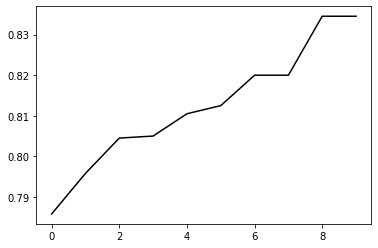

In [10]:
accs = [0.7958, 0.8125, 0.80500, 0.82, 0.83454, 0.7858, 0.8105, 0.804500, 0.82, 0.83454]
import matplotlib.pyplot as plt
data = accs
data = sorted(data)
plt.plot(list(range(len(accs))), data, 'k')
plt.show()

In [40]:
accs=[1.1599838733673096, ]

Precision:  0.963963963963964
Recall:  0.9907407407407407


c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


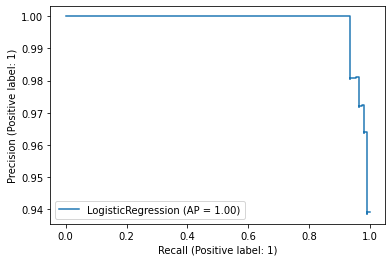

In [41]:
#Importing the required libraries
from sklearn import datasets
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
 
#Loading the data
data = datasets.load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
 
#Splitting the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
                                    df.iloc[:,:-1], df.iloc[:,-1], test_size=0.3, random_state=42)
 
# Initialize and fit the Model
model = LogisticRegression()
model.fit(X_train, y_train)
 
#Make prediction on the test set
pred = model.predict(X_test)
 
#calculating precision and reall
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
 
print('Precision: ',precision)
print('Recall: ',recall)
 
#Plotting Precision-Recall Curve
disp = plot_precision_recall_curve(model, X_test, y_test)

In [42]:
print(y_test)

204    1
70     0
131    0
431    1
540    1
      ..
69     1
542    1
176    1
501    0
247    1
Name: target, Length: 171, dtype: int32


In [43]:
print(pred)

[1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0
 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1]


In [1]:
# pt ResNet 
accs = [0.8333333134651184, 0.8333333134651184, 0.9333333373069763, 0.8999999761581421, 0.8666666746139526, 0.8999999761581421, 0.7333333492279053, 0.8999999761581421, 0.7333333492279053, 0.9666666388511658]
precisions = [0.9692307692307692, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9692307692307692, 1.0]
recalls = [0.8333333333333334, 0.8333333333333334, 0.9333333333333333, 0.9, 0.8666666666666667, 0.9, 0.7333333333333333, 0.9, 0.7333333333333333, 0.9666666666666667]
fmeasures = [0.8872258064516129, 0.9032258064516128, 0.9650000000000001, 0.9465116279069767, 0.9263157894736842, 0.9444444444444445, 0.8412698412698413, 0.9457142857142856, 0.8125714285714286, 0.9828282828282828]


In [2]:
import numpy as np
import scipy.stats as st

#define sample data
data = accs

#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(0.8040215188965151, 0.9159784620299986)

In [3]:
data = precisions

#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(0.9845655090759343, 1.0031267986163732)

In [4]:
data = recalls

#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(0.8040215198496445, 0.9159784801503554)

In [5]:
data = fmeasures

#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(0.8764254778012908, 0.9545959848211432)